In [3]:
! jupyter trust notebook.ipynb

!pip install folium matplotlib mapclassify geopandas -q -q -q
!pip install folium matplotlib mapclassify -q -q -q
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np

[TrustNotebookApp] Writing notebook-signing key to /home/repl/.local/share/jupyter/notebook_secret
Signing notebook: notebook.ipynb
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
redshift-connector 2.0.908 requires pytz<2022.2,>=2020.1, but you have pytz 2022.6 which is incompatible.
redshift-connector 2.0.908 requires requests<2.28.1,>=2.23.0, but you have requests 2.28.1 which is incompatible.
pandas-profiling 3.4.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.6.2 which is incompatible.
mlflow 2.0.1 requires packaging<22, but you have packaging 22.0 which is incompatible.
markdown-it-py 1.1.0 requires attrs<22,>=19, but you have attrs 22.1.0 which is incompatible.
cartopy 0.21.0 requires shapely<2,>=1.6.4, but you have shapely 2.0.0 which is incompatible.
pythonwhat 2.23.1 requires asttokens~=1.1.10, but you have asttokens 2.0.8 which is incompat

![coffee beans](coffeeBeans.png "Coffee Beans")

<h1 style="color:#715859"> <center> <u>1: INTRODUCTION </u></center></h1>

<h4>Objective</h4> Identify three neighborhoods in Denver, Colorado for The Coffee Shop to expand into. 

The Coffee Shop serves high-quality and responsibly sourced coffee, pastries, and sandwiches. The Coffee Shop appeals to <u> 20–35-year-olds</u> and, ideally, would be located close to <u>affluent households</u>. 

<h4>Goal</h4> Maximize the number of customers who visit the store.

<h4>The Data</h4> We have 3 datasets to draw insights from. These are:
<ol>
<li> <i>Starbucks locations in Denver, Colorado</i>: Which provides information about Starbucks store number, store name, phone number, address, postal code and geographical coordinates.
<li><i> Neighborhoods' geographical information</i>: Which provides information about the neighbourhood ID, neighbourhood name and coordinates in the form of a polygon that defined the neighbourhood.
<li><i> Demographic information</i>: Which provides information about the neighbourhood ID, name, population, age (by age group), number of households, number of families, and the number of households with income above 100 thousand USD per year.
</ol>

<h5>Missing Values</h5>
<ol>
<li> The "Starbucks" dataset has missing values for the street address and phone number, however, this is not relevant to the current analysis. 
<li>"Neighbourhoods' geographical information" does not have any missing data. 
<li> The "Demographic information" dataset contains missing values relating to the number high-income households in each neighbourhood. This is an issue for the analysis.
</ol>
Since there are quite a few missing entries (30 missing out of 78 total entries) these observations can not simply be dropped without limiting the analysis. Instead, we are going to impute the missing values using KNN.

In [4]:
from sklearn.impute import KNNImputer

# - LOAD DATA SETS
Starbucks = pd.read_csv('./data/denver.csv') 
neighborhoods = gpd.read_file('./data/neighborhoods.shp') 
census = pd.read_csv('./data/census.csv')

# - CONVERTING DATAFRAMES TO GEOPANDAS
# ---- Converting Starbucks to geopandas
Starbucks_denver=Starbucks[['Name','PostalCode','Longitude','Latitude']]
geo_star = gpd.GeoDataFrame(
    Starbucks_denver, geometry=gpd.points_from_xy(Starbucks_denver.Longitude, Starbucks_denver.Latitude))

# - IMPUTING MISSING DATA
census_numerical = census.select_dtypes(include=[np.number]) # Selecting only numerical since categorical identifyers are not needed
imputer = KNNImputer(n_neighbors=2)                          # defining KNN parameters
census_array=imputer.fit_transform(census_numerical)         # Fitting KNN model
census_filled = pd.DataFrame(census_array, 
                             columns = ['NBHD_ID', 'POPULATION_2010', 
                                        'AGE_LESS_18', 'AGE_18_TO_34',
                                        'AGE_35_TO_65', 'AGE_65_PLUS', 
                                        'NUM_HOUSEHOLDS', 'FAMILIES',
                                        'NUM_HHLD_100K+'])    # Converting array back to dataframe, adding colum names back in
census_1= census[['NBHD_ID','NBHD_NAME']]                     # selecting relivant columns to merge back into cencus_filled
CensusFilled  = census_filled.merge(census_1, on='NBHD_ID', how='left') # merging names back in

# ---- Merging neighborhoods with cenus and converting to geopandas
neighborhood_2  = CensusFilled.merge(neighborhoods, on='NBHD_NAME', how='left')
comnined_neighborhood = gpd.GeoDataFrame(neighborhood_2)

In [5]:
comnined_neighborhood.head(2)

NBHD_ID_x  ...                                           geometry
0        1.0  ...  POLYGON ((-104.99238 39.69666, -104.99295 39.6...
1        2.0  ...  POLYGON ((-105.00042 39.74552, -105.00041 39.7...

[2 rows x 12 columns]

In [6]:
geo_star.head(2)

Name  ...                     geometry
0  Auraria Tivoli - Student Union  ...  POINT (-105.01000 39.75000)
1              Grand Hyatt Denver  ...  POINT (-104.99000 39.75000)

[2 rows x 5 columns]

In [3]:
comnined_neighborhood['Starbucks']=comnined_neighborhood.apply(lambda x: geo_star['geometry'].within(x['geometry']).sum(), axis=1)

<h4>A Brief Exploration of the Data</h4>

The first step in analyzing these data is to visualize the neighborhoods. 
The graph below displays all 78 neighborhoods in Denver...

In [3]:
import folium
import branca.colormap as cmp

! jupyter trust notebook.ipynb

m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="AGE_18_TO_34",  # make choropleth based on target age column
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     cmap='winter',
     legend_kwds=dict(), # use colorbar or not
     name="Neighborhoods by Age" # name of the layer in the map
)
folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  

Signing notebook: notebook.ipynb


![NeighbourhoodMap](One_neighbourhoods.png "NeighbourhoodMap")

<i>
<p style="font-size:11px"> Note: I am using folium choropleth maps here. However, without running the cell, the message "Make this Notebook Trusted to load map" appears instead of the map. There are workarounds to this (including using a different browser or opening the notebook with a different viewer), but these are not practical solutions for this application. In order for it to work for everyone, I have included pictures of the maps instead. The full interactive map with will be in Appendix C - Mapping </i>

**Market Density**

For this analysis we are interested in calculating the market density (number of potential customers of a product within a unit of land area). This is because higher density markets are good for word-of-mouth marketing and allows businesses to grow faster (hbr.org/2019/03/why-businesses-should-know-where-their-densest-markets-are ).

We will calculate densities using the following method:

$$Density=\frac{Population Count}{Land Area(km^2)}$$

A separate calculation will be done for each variable of interest (<i> i.e.</i> "AGE_18_TO_34","NUM_HHLD_100K+","Starbucks").

In [4]:
# Counting the number of Starbucks 
comnined_neighborhood['Starbucks']=comnined_neighborhood.apply(lambda x: geo_star['geometry'].within(x['geometry']).sum(), axis=1)

# Calculating the area of each neighbourhoods
comnined_neighborhood.crs = "EPSG:4326"
comnined_neighborhood['geometry']= comnined_neighborhood['geometry'].to_crs({'proj':'cea'}) # equal area projection to estimate size
comnined_neighborhood["area"] = comnined_neighborhood['geometry'].area/ 10**6 # are in KM^2

# Density target age
comnined_neighborhood['proportion_pop']=comnined_neighborhood["AGE_18_TO_34"]/comnined_neighborhood["area"]

# Density high-income households
comnined_neighborhood["HHI_per_area"]=comnined_neighborhood["NUM_HHLD_100K+"]/comnined_neighborhood["area"]

# Density Starbucks
comnined_neighborhood['Starbucks_density']=comnined_neighborhood['Starbucks']/comnined_neighborhood['area']

Now lets checking the correlation between our variables of interest (target age, target income and Starbucks locations) and other relevant variables. This will give us an idea of the relationship between variables in the dataset.

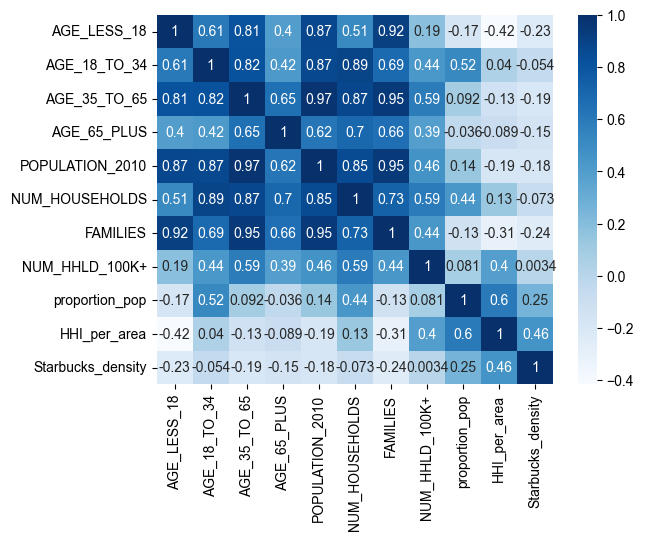

In [5]:
population_corr= comnined_neighborhood[['AGE_LESS_18', 'AGE_18_TO_34',
       'AGE_35_TO_65', 'AGE_65_PLUS','POPULATION_2010', 'NUM_HOUSEHOLDS', 'FAMILIES',
       'NUM_HHLD_100K+', 'proportion_pop', 'HHI_per_area', 'Starbucks_density']]
corr= population_corr.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
sns.set(rc={'figure.figsize':(15,15)})

The results are not surprising (strong correlation between the population in 2010 and the number of families in a neighbourhood etc.).
One standout point is that Starbucks density is not correlated with any of our 'age' variables, and is only weekly related (r=0.46) to the amount of high-income households per square kilometers.

Reassuringly, the density measures for the target age group and target income group are positively associated with a moderate correlation of 0.60. 

<h1 style="color:#715859"> <center><u>2: ANALYSIS </u></center></h1>

<h3 style="color:#5F4A4A;"> <center><i> 2.1: Analysis of target demographic </i></center></h3>
Our target demographic consists of i) high-income consumers and ii) 20-35 year-olds. 
<p>

In this section we will answer 3 questions: 1) where do the 20-35 year-olds  live?, 2) Where are high-income houses clustered? and 3) Which neighbourhoods have the highest proportion of people in the target demographic?

<h4> Where do the 20-35 year-olds  live?</h4> 

Our data does not give us an exact population estimate for 20-35 year-olds, the closest estimate available is for 18-34 year-olds.

The graph below displays the population density of 18-34 year-olds by neighbourhood.

Neighbourhoods highlighted in green (such as North Capitol Hill, Capitol Hill and Speer) are home to a greater proportion of the target age group. 

In [6]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="proportion_pop",  
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Age"
)
folium.TileLayer('Stamen Toner', control=True).add_to(m)  
folium.LayerControl().add_to(m) 
m  

![NeighbourhoodMap_bypop](TWOProportion_pop.png "Population by Neighbourhood")

We can see that 18-34 year-olds tend to be clustered in the downtown area. Thus, in our search for a new location, downtown Denver seems to be a good starting point.

<h4>Where are high-income houses clustered?</h4>

Now we will determine where high-income households are clustered. Again, we will be using our density measures.

In [7]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="HHI_per_area",  
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Age" 
)
folium.TileLayer('Stamen Toner', control=True).add_to(m) 
folium.LayerControl().add_to(m)  
m  

![NeighbourhoodMap_byIncome](ThreeHHI_per_area.png "Population by Income")

We can see that high-income households are diffused through a greater proportion of the city (including Downtown, Northwest, Northeast and Southeast Denver). 

Now that we know where the majority of high-income houses, and 18-34 year-olds, are clustered. We will determine which neighbourhoods have the highest proportion of people in our target demographic.</p></i>

<h4> Which neighbourhoods have the highest proportion of people in the target demographic?</h4>

The graph below plots the density of high-income households by the density of the target age group. The region of the graph highlighted in green shows the area of interest.

<p style="color:#0672C2;"><b>Neighbourhoods in the upper right section of the graph (such as North Capitol Hill, Capitol Hill) are home to the highest proportion of people in the target market</b>.

<AxesSubplot: title={'center': 'Ideal Cofeeshop location by Neighbourhood'}, xlabel='People age 18-35', ylabel='Household income'>

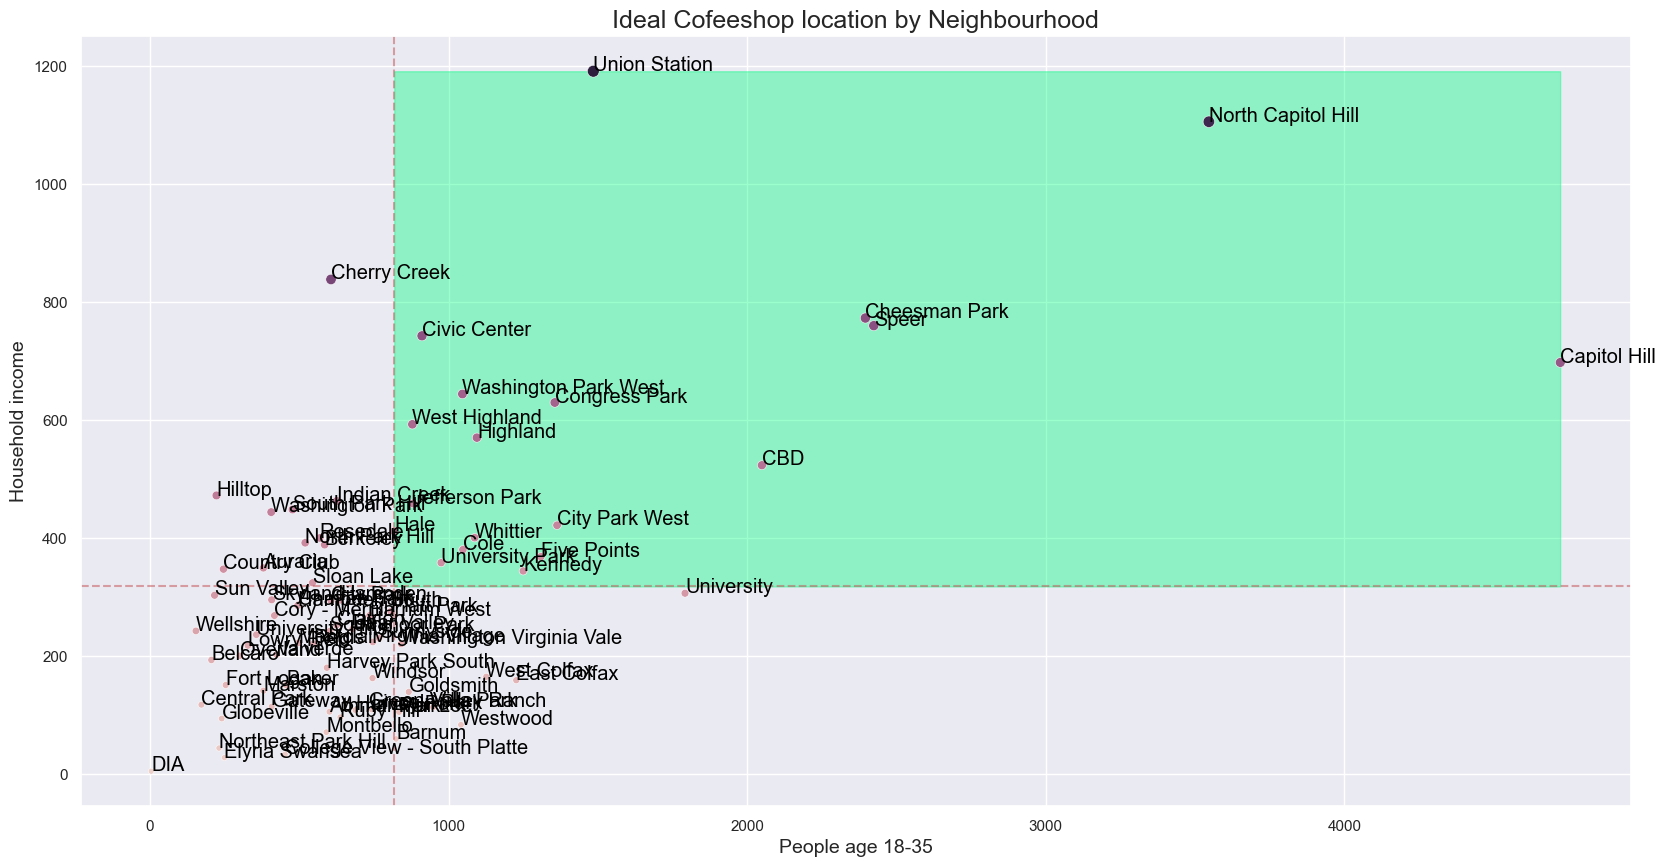

In [8]:
import numpy as np
import matplotlib.pyplot as plt

data= comnined_neighborhood
x=comnined_neighborhood['proportion_pop']
y=comnined_neighborhood['HHI_per_area']
z= comnined_neighborhood['HHI_per_area']

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    p1 = sns.scatterplot(x, y, data=data, size=z, hue=z, legend=False)
    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='black') for line in range(0,data.shape[0])]
    #adjust_text(texts)
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

plt.figure(figsize=(20,10))
plt.grid(c='white')
plt.rcParams['axes.facecolor'] = '#EEF3F4'

# Add horizontal and vertical lines to mark the average values
avh_HIH = data['HHI_per_area'].mean()
avh_HIH = data['HHI_per_area'].mean()
avh_people = data['proportion_pop'].mean()
max_people_per_market = data['proportion_pop'].max()
max_HIH = data['HHI_per_area'].max()

plt.axhline(y=avh_HIH, color='r', linestyle='--', alpha=0.5) # Defining the line colour and style
plt.axvline(x=avh_people, color='r', linestyle='--', alpha=0.5)

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avh_people, max_people_per_market), y1=avh_HIH, y2=max_HIH, color='#05FD83', alpha=0.4)

# Draw and label the neighbourhood points
scatter_text('proportion_pop', 'HHI_per_area', 'NBHD_NAME',
             data = data, 
             title = 'Ideal Cofeeshop location by Neighbourhood', 
             xlabel = 'People age 18-35',
             ylabel = 'Household income')

<h3 style="color:#5F4A4A;"> <center><i> 2.2: Analysis of competitors (Starbucks) </i></center></h3>

While Starbucks does not directly compete with The Coffee Shop, they are a major player in the coffee market. So, in this section we turn to an analysis of Starbucks locations. We will answer 2 questions 1) Which neighborhoods have the highest Starbucks density? and 2) Will the presence of a Starbucks location help or hurt us?
<p>

<h4> Which neighborhoods have the highest Starbucks density?</h4>

First, lets plot all of the Starbucks locations to see where they are concentrated using the same density method mentioned previously.

In order to do this, we will calculate how many Starbucks locations there are in each neighborhood, then divide that number by the area of each neighborhood. 

In the graph below we can see that Starbucks locations are clustered downtown Denver.

In [9]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=13)

comnined_neighborhood.explore(
     m=m,
     column="Starbucks_density", 
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Starbucks Density")

# ---------- PLOTTING LOCATIONS
for lat,lon,tip  in zip(geo_star.Latitude, geo_star.Longitude, geo_star.Name):
    folium.Marker(location=[lat,lon], tooltip = tip).add_to(m)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  

![Starbucks_Location_Markers](StarbucksLocationMarkers.png "Starbucks Location Markers")

![Starbucks_by_Neighbourhood](FoutStarbucks.png "Starbucks by Neighbourhood")

<i>
<p style="font-size:12px"> Note: While none of the starbucks locations are duplicates, some of the latitude and long locations are duplicates (for example there may be two starbucks locations in a mall). This means that markers can be misleading. The areas of the clorepeth map hilighted in green are a better indicator

<h1 style="color:#715859"><center><u>3: RECOMENDATIONS </u></center></h1>


In creating the plot below, the dataset was filtered for neighborhoods with a higher than average density of 1) high-income households 2) 18-34 year-olds and 3) Starbucks locations. Ultimately, 7 neighborhoods met these criteria. 

However, we run into a problem when trying to narrow the list down to only 3 neighbourhoods. Specifically, there is a trade-off between maximizing the number of high-income households vs. maximizing the number of 18-34 year-olds vs. maximizing the number of Starbucks locations. 

For example, choosing between Union Station and Cheeseman Park would require us to decide whether we value the income requirement over the age requirement, since Cheeseman Park scores comparatively higher on the age requirement as compared to Union Station (1,484,67 vs. 2,395.73), while Union Station scores comparatively higher on the income requirement as compared to Cheeseman Park (1191.61 vs. 773.41). 

In [10]:
import plotly.express as px
import plotly.graph_objects as go

# Filter data for points higher than average, this will make graph easyer to read
comnined_neighborhood_filtered = comnined_neighborhood[(comnined_neighborhood["proportion_pop"] > comnined_neighborhood["proportion_pop"].mean()) & (comnined_neighborhood["HHI_per_area"]>comnined_neighborhood["HHI_per_area"].mean()) &(comnined_neighborhood["Starbucks_density"]>comnined_neighborhood["Starbucks_density"].mean())] 

# Creating the plot
fig = px.scatter_3d(comnined_neighborhood_filtered, 
                    x='proportion_pop', 
                    y='HHI_per_area', 
                    z='Starbucks_density',
                    labels={
                     "proportion_pop": "Age (density)",
                     "HHI_per_area": "Income (density)",
                     "Starbucks_density": "Starbucks (density)"},
                    text="NBHD_NAME")
                    
# updating figure size, margin, and plot title
fig.update_layout(height=600,width=600,
                  margin=dict(
                      l=1,
                      r=1,
                      b=1,
                      t=30,
                      pad=1),
                  title_text='Ideal Neighborhoods')

It becomes apparent that we will need some way of weighting these criteria. Thus, a desirability score for each neighborhood will be calculated. For this method, we will need to determine weights for each criteria.

<i><u> Target Demographic: </u></i> From past research we see that coffee consumption increases with <b> both </b> age and income. People ages 51-70 years are the largest consumers of coffee as are higher income groups. Since only higher income groups are relevant to us, we will weight income higher than the age (45% importance to income and 35% importance to age) <a href="#footnote-1">[1]</a>.

<i><u>Starbucks:</u></i> here we will turn to an observation: competitors tend to cluster together. This can be explained by “Hotelling’s Model of Spatial Competition.” There are two factors at play here. 

<li> Price competition, whereby firms compete in prices and profits are eroded (this pushes stores apart)
<li> Maximizing market share, whereby stores locate in places where customers are (this pulls store together)
<p>
    
Since Starbucks and The Coffee Shop do not share the same customers, we don’t expect price competition to be particularly strong. Thus, neighborhoods where Starbucks are located are likely to be ideal areas for coffee shops. The density of Starbucks coffee shops will be weighted at 20%.
    
The formula for the desierability score is as follows:
    $$Desirability Score=Income(0.45)+Age(0.35)+Starbucks(0.20)$$

    
<hr style="width:50%;text-align:left;margin-left:0">   
<p id="footnote-1">[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7469044/ </p>


After calculating the desirability score for each neighbourhood, we can easily graph the top 3 neighborhoods for the Coffee Shop to consider expanding into in Denver.

In [11]:
import plotly.graph_objects as go

# Defining weights here, this will make it easy to change if nessisary
Income_weight=0.45
Age_weight=0.35
Starbucks_weight=0.20

# Calculating the desierability score for each neighborhood
comnined_neighborhood["score"]=comnined_neighborhood["HHI_per_area"]*Income_weight+comnined_neighborhood["proportion_pop"]*Age_weight+comnined_neighborhood["Starbucks_density"]*Starbucks_weight

# Determining the top 10 neighborhoods by score
top_scores=comnined_neighborhood[['NBHD_NAME','score']]
top_scores= top_scores.sort_values(by='score',ascending=False)
top_10= top_scores.head(10)

# Graphing Top 3 Neighbourhoods
top=(0,1,2) # Only interested in the top 3 results 

colors = ['#32B99D',] * 10  # Defining the colour of all the bars
for i in top:
    colors[i] = '#DA0A30'   # changing the colour of the top 3 bars to red

fig = go.Figure(data=[go.Bar(
    x=top_10['NBHD_NAME'],
    y=top_10['score'],
    marker_color=colors
)])

fig.update_layout(
    autosize=False,
    width=700,
    height=450,
    showlegend=False,
    title_text='Top 3 Neighborhoods'
)

<p style="color:#0672C2;"><b>As the graph displays, Capitol Hill, North Capitol Hill and Speer are the top choices.</p> </b>

However, these recommendations are dependent on the choice of weights. Choosing the weights is not an exact science (it involves some judgment calls). For example, if we weigh income at 80%, age at 10% and Starbucks to 10% North Capitol Hill, Union Station and Capitol Hill become the top choices. As new information comes to light (perhaps more information about direct competitors) the recommendations might change. 

However, at present the three neighbourhoods highlighted appear to be the best choices.

Thanks for reading. I hope you enjoyed my analysis!

<H1 style="color:#715859"><center><u> I: APPENDIX A </u></center></H1>
<h3>Experimenting with Weights</H3>

While I believe that the value of the weights need to be set by an individual using some logic, it would be interesting to see how much the recommendations will change when changing the weights. 

Below, I will try different combinations of randomly generated weights to see what would happen:

In [12]:
from random import randint

# defining lists that will be filled throught the for loop
weight=[]   # creating a list to store the combinations of weights
top_3=[]      # creating a list to store the highest rated neighbourhoods

# the number of times the for loop will run
n=100

# creating a new dataframe to use
top3_test=comnined_neighborhood

# creating the for loop
for i in range(n):
    
    # generating random weights that will add to 100
    weight1 = (randint(0,100))
    weight2 = (randint(0,(100-weight1)))
    weight3 = 100 - (weight1 + weight2)  
    
    # calculating a score based on those weights, selecting only the neighbourhood name and score, sorting the results
    top3_test['score']= top3_test['HHI_per_area']*weight1+top3_test['proportion_pop']*weight2+top3_test['Starbucks_density']*weight3
    top3_test_2=top3_test[['NBHD_NAME','score']]
    top3_test_2= top3_test_2.sort_values(by='score',ascending=False)
    
    # adding the weights and top neighbourhoods to the lists ( each neighbourhood in a seprate list)
    weight.append([weight1,weight2,weight3])
    top_3.append(pd.Series(top3_test_2['NBHD_NAME'].iloc[:3]).to_string(index=False))

    # adding the lists to the dataframe
    results=pd.DataFrame({})
    results['weight']=weight
    results['top_3']=top_3

results['top_3'].value_counts()

      Capitol Hill\nNorth Capitol Hill\n             Speer    44
North Capitol Hill\n     Union Station\n      Capitol Hill    22
North Capitol Hill\n      Capitol Hill\n     Union Station    11
     Union Station\nNorth Capitol Hill\n      Cherry Creek    10
      Capitol Hill\nNorth Capitol Hill\n     Cheesman Park     6
      Capitol Hill\nNorth Capitol Hill\n     Union Station     5
     Union Station\nNorth Capitol Hill\n      Capitol Hill     2
Name: top_3, dtype: int64

I have randomly generated weights 100 times, we can see that the majority of weight combinations yield the result of 1)Capitol Hill, 2)North Capitol Hill and 3)Speer. This is an encouraging result! 

In [13]:
results.head()

weight                                              top_3
0  [22, 44, 34]        Capitol Hill\nNorth Capitol Hill\n      ...
1  [32, 40, 28]        Capitol Hill\nNorth Capitol Hill\n      ...
2   [32, 7, 61]  North Capitol Hill\n      Capitol Hill\n     U...
3   [8, 30, 62]        Capitol Hill\nNorth Capitol Hill\n      ...
4  [11, 74, 15]        Capitol Hill\nNorth Capitol Hill\n      ...

<H1 style="color:#715859"><center><u> II: APPENDIX B  </u></center></H1>

This section contains the process of detecting duplicate entries and the exploration of extreme points in the dataset. Ultimatly, I did not find any duplicate values, nor did I decide to drop any extreme values.

<h3> Duplicates </h3>

In [14]:
# Checking Starbucks dataset for duplicates
StarbucksTest= Starbucks
neighborhoodsTest = neighborhoods
censusTest = census
DuplicateTest=comnined_neighborhood

# Find duplicate values
StarbucksTest['Duplicate'] = StarbucksTest.duplicated(keep=False).map({True:'Yes', False:'No'})
neighborhoodsTest['Duplicate'] = neighborhoodsTest.duplicated(keep=False).map({True:'Yes', False:'No'})
censusTest['Duplicate'] = censusTest.duplicated(keep=False).map({True:'Yes', False:'No'})
DuplicateTest['Duplicate'] = DuplicateTest.duplicated(keep=False).map({True:'Yes', False:'No'})

# Print results
print('StarbucksTest duplicates',StarbucksTest['Duplicate'].unique())
print('neighborhoodsTest duplicates',neighborhoodsTest['Duplicate'].unique())
print('censusTest duplicates',censusTest['Duplicate'].unique())
print('DuplicateTest duplicates',DuplicateTest['Duplicate'].unique())

StarbucksTest duplicates ['No']
neighborhoodsTest duplicates ['No']
censusTest duplicates ['No']
DuplicateTest duplicates ['No']


There are no duplicate valies in the dataset

<h3> Outliers </h3>

In [15]:
selected = comnined_neighborhood[['POPULATION_2010', 'AGE_LESS_18', 'AGE_18_TO_34',
       'AGE_35_TO_65', 'AGE_65_PLUS', 'NUM_HOUSEHOLDS', 'FAMILIES',
       'NUM_HHLD_100K+']]

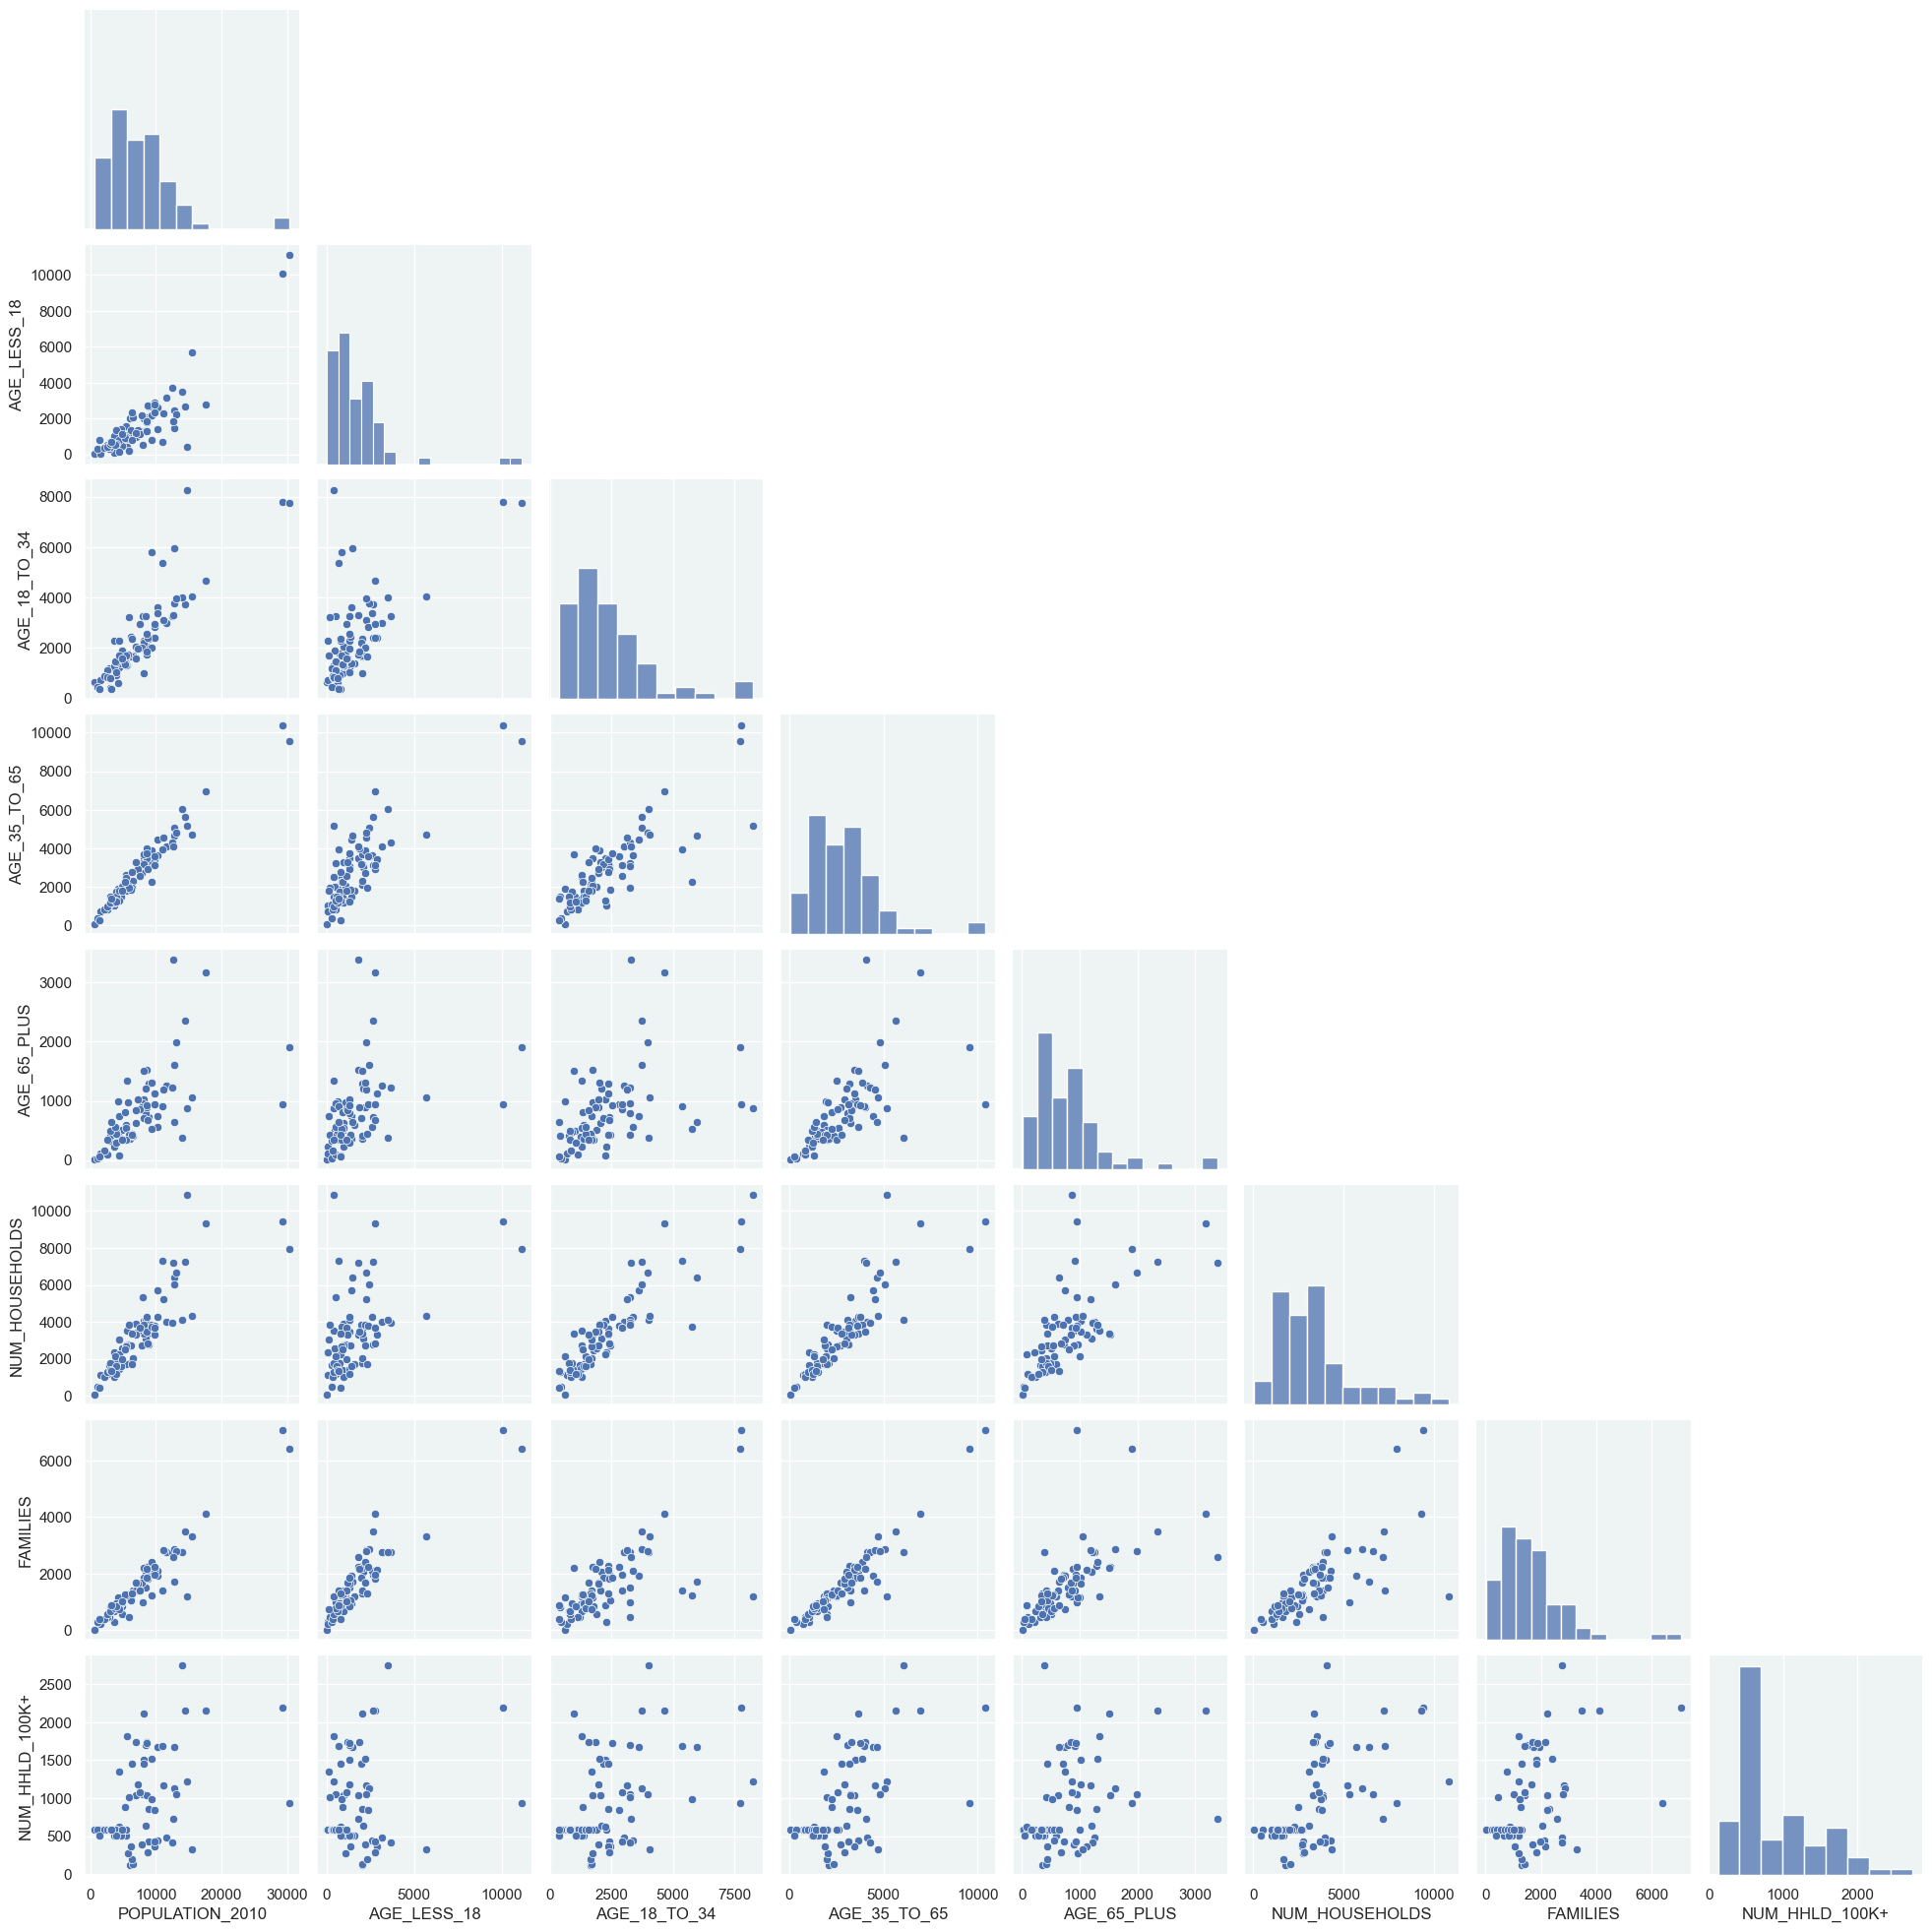

In [16]:
sns.pairplot(selected, corner=True)

In [17]:
selected.describe()

POPULATION_2010   AGE_LESS_18  AGE_18_TO_34  AGE_35_TO_65  AGE_65_PLUS  \
count        78.000000     78.000000     78.000000     78.000000    78.000000   
mean       7694.333333   1650.846154   2375.358974   2871.564103   796.564103   
std        5166.830998   1778.296281   1657.967783   1831.507495   617.881773   
min         705.000000      7.000000    360.000000     57.000000     6.000000   
25%        4213.000000    680.750000   1307.250000   1514.000000   404.000000   
50%        6701.500000   1300.000000   1984.000000   2594.000000   665.500000   
75%        9640.000000   2150.500000   3090.500000   3667.000000   987.000000   
max       30348.000000  11137.000000   8274.000000  10405.000000  3383.000000   

       NUM_HOUSEHOLDS     FAMILIES  NUM_HHLD_100K+  
count       78.000000    78.000000       78.000000  
mean      3373.166667  1602.615385      903.217949  
std       2145.793889  1183.566251      571.379048  
min         60.000000    15.000000      120.000000  
25%       1773.750000   855.000000      525.000000  
50%       3086.000000  1290.000000      585.000000  
75%       3985.750000  2095.000000     1173.750000  
max      10856.000000  7056.000000     2748.000000

There are several extreme values (where the maximum value is greater than the 75% percentile). These are from Montbello,Gateway - Green Valley Ranch,Windsor,Capitol Hill.

In [18]:
for x in selected.columns:
    print(comnined_neighborhood.loc[comnined_neighborhood[x] == comnined_neighborhood[x].max()],'\n''\n''\n')

    NBHD_ID_x  POPULATION_2010  AGE_LESS_18  AGE_18_TO_34  AGE_35_TO_65  \
44       45.0          30348.0      11137.0        7742.0        9561.0   

    AGE_65_PLUS  NUM_HOUSEHOLDS  FAMILIES  NUM_HHLD_100K+  NBHD_NAME  \
44       1908.0          7942.0    6399.0           939.0  Montbello   

    NBHD_ID_y                                           geometry  Starbucks  \
44         45  POLYGON ((-11667384.473 4060489.147, -11668425...          1   

         area  proportion_pop  HHI_per_area  Starbucks_density         score  \
44  13.110198      590.532669     71.623634           0.076277  15305.261251   

   Duplicate  
44        No   



    NBHD_ID_x  POPULATION_2010  AGE_LESS_18  AGE_18_TO_34  AGE_35_TO_65  \
44       45.0          30348.0      11137.0        7742.0        9561.0   

    AGE_65_PLUS  NUM_HOUSEHOLDS  FAMILIES  NUM_HHLD_100K+  NBHD_NAME  \
44       1908.0          7942.0    6399.0           939.0  Montbello   

    NBHD_ID_y                                         

However, it is not clear that these represent errors in data processing, therefore, none of the data points will be excluded from the analysis.

<H1 style="color:#715859"><center><u> III: APPENDIX C  </u></center></H1>

<h3> Mapping </h3>

1. Mapping all 78 neighbourhoods by count of people ages 18-34

In [19]:
import folium
import branca.colormap as cmp

! jupyter trust notebook.ipynb

m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="AGE_18_TO_34",  # make choropleth based on target age column
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     cmap='winter',
     legend_kwds=dict(), # use colorbar or not
     name="Neighborhoods by Age" # name of the layer in the map
)
folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  

Signing notebook: notebook.ipynb


2. Mapping taget age group by neighbourhood

In [20]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="proportion_pop",  
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Age"
)
folium.TileLayer('Stamen Toner', control=True).add_to(m)  
folium.LayerControl().add_to(m) 
m  

3. Mapping By Income

In [21]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=12)

comnined_neighborhood.explore(
     m=m,
     column="HHI_per_area",  
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Age" 
)
folium.TileLayer('Stamen Toner', control=True).add_to(m) 
folium.LayerControl().add_to(m)  
m  

4. Mapping By Starbucks Location

In [22]:
m= folium.Map(location=[39.7392, -104.9903],zoom_start=13)

comnined_neighborhood.explore(
     m=m,
     column="Starbucks_density", 
     scheme="naturalbreaks",  
     legend=True, 
     k=10, 
     cmap='winter',
     legend_kwds=dict(), 
     name="Neighborhoods by Starbucks Density")

# ---------- PLOTTING LOCATIONS
for lat,lon,tip  in zip(geo_star.Latitude, geo_star.Longitude, geo_star.Name):
    folium.Marker(location=[lat,lon], tooltip = tip).add_to(m)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  